In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/tryMaxMMRwidInitial.csv')

In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.14 s, sys: 55.8 ms, total: 6.2 s
Wall time: 6.2 s


In [5]:

twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','twoMMRstrengthnear','twoMMRstrengthfar','twoMMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter']+twoBRwidth
MMRDataTest = ['threeBRfillfac', 'EMcrossnear','EMcrossfar','EMcrossouter']+twoBRwidth
TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

In [11]:
dataset

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0.221502,0.098431,9.878834e-03,NaN,0.013642,0.007103,0.300893,0.093415,0.001595,...,0.023629,0.061076,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,1
1,1,0.190647,0.009185,1.703367e-03,NaN,0.019474,0.015939,0.403777,0.249341,0.003783,...,0.013028,0.085497,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,1
2,2,0.125660,0.426660,1.310313e-01,NaN,0.033117,0.022168,0.720557,0.000531,0.000266,...,0.011262,0.040973,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,1
3,3,0.216684,0.002876,1.857040e-07,NaN,0.004557,0.001577,0.235460,0.027521,0.013379,...,0.000034,0.057376,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,1
4,4,0.024455,0.423830,1.145611e-01,NaN,0.002436,0.000582,0.034058,0.079484,0.053510,...,0.007250,0.018995,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,NaN,0.016075,0.016330,0.664222,0.001175,0.000000,...,0.038914,0.154595,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,1
138539,138539,0.251338,0.749336,1.701463e-03,NaN,0.003767,0.002099,0.272822,0.017013,0.004713,...,0.029073,0.030636,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,1
138540,138540,0.131799,0.324267,2.940005e-02,NaN,0.017772,0.017278,0.366664,0.059764,0.006983,...,0.051811,0.083804,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,1
138541,138541,0.209454,1.205802,5.207774e-02,NaN,0.033014,0.057969,0.395073,0.029166,0.002591,...,0.068171,0.055297,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,1


In [6]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [7]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull


In [8]:
scrambled = filtData.sample(frac=1)

In [9]:
scrambled = scrambled.reset_index()

In [10]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,...,EPnear,EMfar,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [12]:
dataset['prelimStable'].value_counts()[False]

14939

In [13]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [14]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [15]:
realTest = test.loc[test['prelimStable']==True]

In [16]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [17]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
train

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,MMRstrengthWMAXnear,...,MEGNO,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,71345,71345,0.079985,0.144616,0.013553,0.078644,0.014850,0.0,0.002755,0.003559,...,33.772929,6.791241,0.625560,0.022276,0.130749,True,False,2.648115e+04,1.240578e+05,0
1,126213,126213,0.050304,0.178815,0.001504,0.170077,0.021202,0.0,0.003113,0.004709,...,62.059175,18.592795,6.692261,0.526682,0.896289,True,False,4.724654e+04,1.914412e+04,0
2,50592,50592,0.587607,0.226601,0.053887,1.215066,0.000000,0.0,0.074555,0.084292,...,31.790785,9.294596,0.117498,0.005659,0.998524,True,False,1.227830e+04,1.289827e+04,0
3,10774,10774,0.177949,0.016799,0.000149,0.047347,0.042338,1.0,0.012038,0.013627,...,1.997248,0.001377,0.449631,0.002657,0.998680,True,True,1.000009e+09,1.000009e+09,0
4,54005,54005,0.129564,0.073922,0.003658,3.076743,0.047409,0.0,0.025167,0.026582,...,2.019660,0.004395,2.529181,0.027740,0.003902,True,False,3.288040e+05,2.876520e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98878,46943,46943,0.069177,0.543436,0.000910,0.109234,0.040683,0.0,0.004517,0.007739,...,179.198440,59.208928,0.522471,0.319314,0.486725,True,False,1.461258e+07,1.077234e+06,0
98879,64153,64153,0.337574,0.053559,0.016207,0.069354,0.058485,0.0,0.018276,0.020744,...,50.256987,7.803172,0.250894,0.001518,0.106371,True,False,2.535857e+04,2.220445e+05,0
98880,18830,18830,0.099916,0.035408,0.000201,0.086755,0.018805,0.0,0.001375,0.001803,...,1.948481,0.021013,0.417320,0.004078,0.256296,True,False,1.559504e+08,7.158479e+08,0
98881,96058,96058,0.087001,0.036046,0.000107,0.093165,0.012217,0.0,0.000688,0.001109,...,5.418860,1.017271,0.533866,0.003033,0.019889,True,False,7.337275e+07,1.732827e+08,0


In [32]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [33]:
testModel.fit(train[MMRDATA], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
resPred = testModel.predict_proba(tT[MMRDATA])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

0.9564732792152886
0.8697052775873886


0.9719568089144447
0.898423577793009

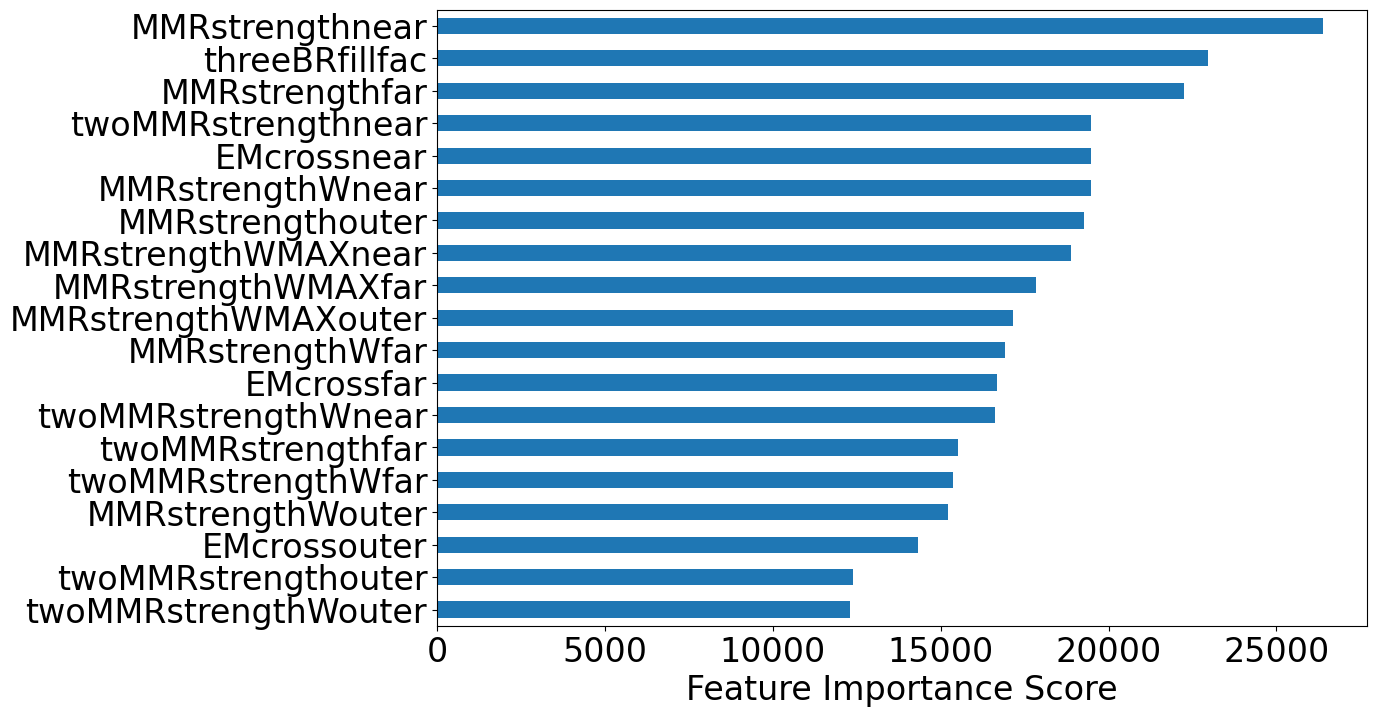

In [35]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [90]:
newModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [91]:
newModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [92]:
resPred = newModel.predict_proba(realTest[features])[:,1]
newAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
newacc = accuracy_score(newModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(newModel.predict(realTest[features]), realTest["Stable"]))

0.9724236065316946
0.9175195178188584


In [98]:
OldModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [99]:
OldModel.fit(train[Oldfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [100]:
resPred = OldModel.predict_proba(realTest[Oldfeatures])[:,1]
oldAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oldacc = accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"]))

0.9682111213159352
0.9100360017798633


In [101]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance)
oneModel.fit(train[OGfeatures], train["Stable"])
resPred = oneModel.predict_proba(realTest[OGfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"]))

0.9531695575960055
0.8871809392823915


In [102]:
print('OG compaired to improved model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-newAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-newacc))/(1-oneMMRacc)}')

OG compaired to improved model
decrease in AOC: 0.3328231447326524
decrease in error: 0.211903908210828


In [103]:
print('new compaired to old model')
print(f'decrease in AOC: {((1-oldAUC)-(1-newAUC))/(1-oldAUC)}')
print(f'decrease in error: {((1-oldacc)-(1-newacc))/(1-oldacc)}')

new compaired to old model
decrease in AOC: 0.017134652518024613
decrease in error: 0.011690647482013613


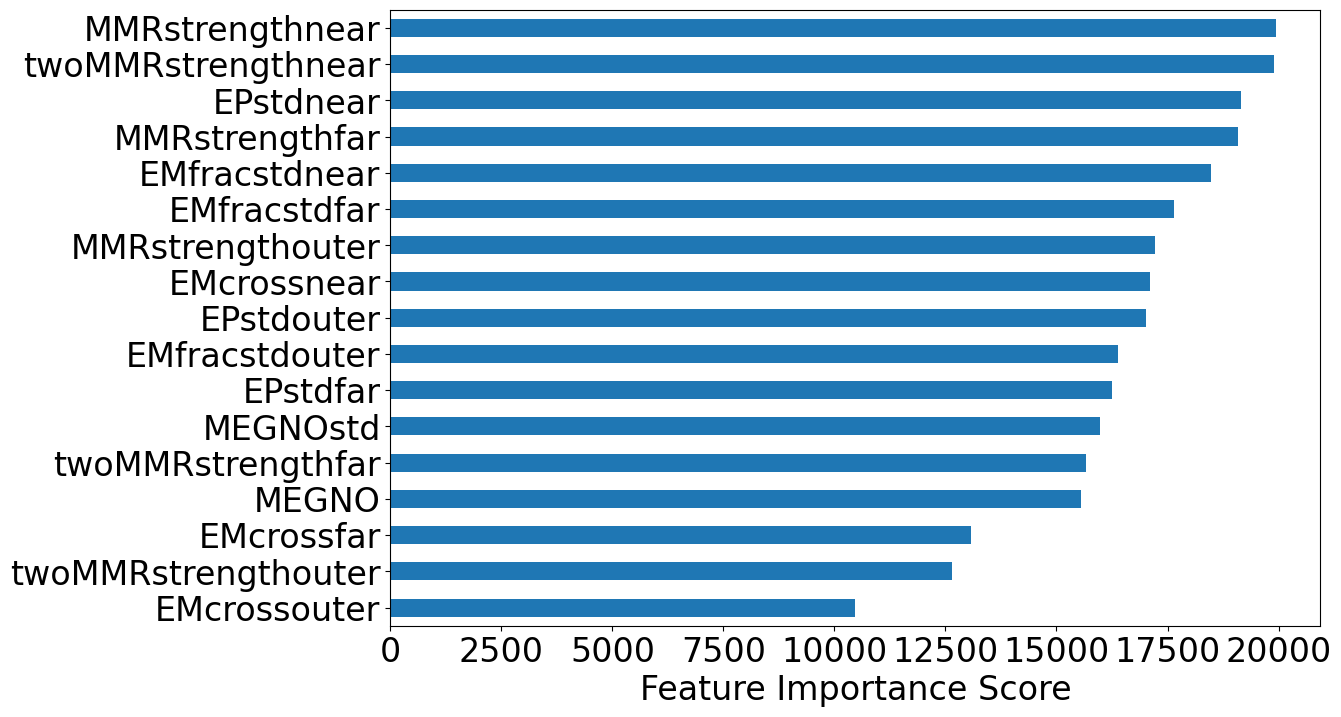

In [104]:
feat_imp = pd.Series(OldModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

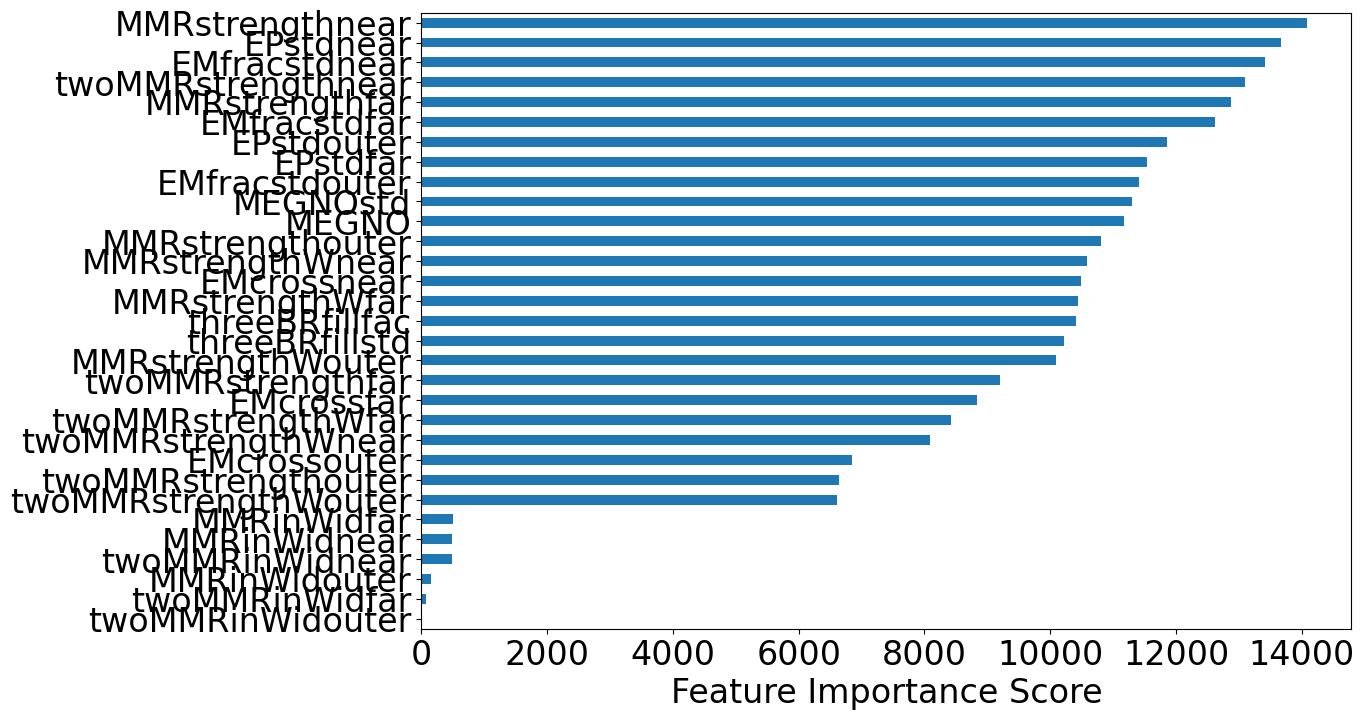

In [93]:
feat_imp = pd.Series(newModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 50.0)

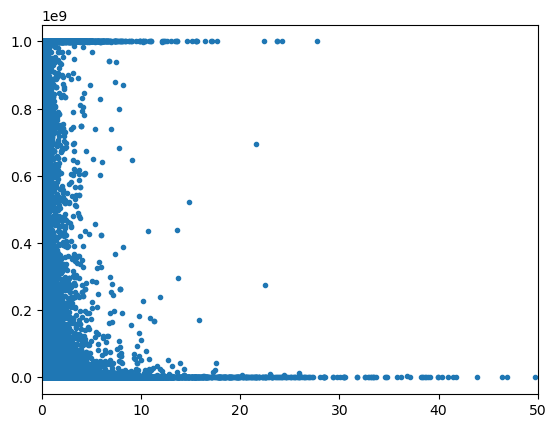

In [115]:
plt.plot(train['threeBRfillfac'],train['instability_time'], marker='.', ls = "")
ax = plt.gca()
ax.set_xlim([0, 50])